# Clustering Neighborhoods Toronto Capstone Project

## Introduction

The project is to explore and cluster the neighborhoods in Toronto. In this project, we will learn how to scrape a webpage and manipulate the dataframe, how to convert neighborhoods into their equivalent latitude and longitude values, as well as the visualization of clustering (neighborhoods). 

We'll use Foursquare API, Google GeoCoder to explore the neighborhoods and segment them. 

We'll run K-mean algorithm to cluster the neighborhoods and examine the clusters. 



## To scrape a webpage and manipulate the dataframe and do visualization

Import the packages for this project

In [1]:
# import packages and mainly use bs4 function to perform the task.

# import urllib
# from urllib.request import urlopen
from bs4 import BeautifulSoup

import os,sys

In [2]:
import pandas as pd # library for data analsysis
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [3]:
target_URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [4]:
# scrape the webpage and form a dataframe

html_doc = requests.get(target_URL).text
soup = BeautifulSoup(html_doc, 'html.parser')

wikitables = soup.find_all('table') 
df = pd.read_html(str(wikitables[0]), index_col=None, header=0)[0]

print(df.shape)
df.head()

(289, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
# to ignore cells with a borough that is Not assigned

new_df = df[ ~ df['Borough'].str.contains('Not assigned')]      
# new_df = df[df.Borough != 'Not assigned']   

print(new_df.shape)
new_df.head()

(212, 3)


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


For different purpose, we my combine the neighborhoods on the same row level if they have a same name of borough.

In [6]:
# using groupby and aggregated function and using comma as to separate the combined values. 

# dfps = new_df.groupby(['Postcode','Borough'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else ', '.join(x))
# print(dfps.shape)
# dfps.tail()

We don't want "Not assigned" as a value appeared in out dataset, so we do some change. 

In [7]:
#  to replace "Not assigned" in column 'Neighbourhood' with the value in 'Borough'.

for i in range(len(new_df)):
    dat_line=new_df.iloc[i,:]
    if dat_line['Neighbourhood'] == 'Not assigned':
        dat_line['Neighbourhood'] = dat_line['Borough']

In [8]:
# check and verify if updated correctly. 

new_df.iloc[6,:]

Postcode                  M7A
Borough          Queen's Park
Neighbourhood    Queen's Park
Name: 8, dtype: object

In [9]:
# display the dataset 

print(new_df.shape)
new_df.head()

(212, 3)


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights



**To get the latitude and the longitude coordinates of each neighborhood**

In [10]:
# we use the given file to obtain the information. 

geo_df = pd.read_csv("Geospatial_Coordinates.csv")
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# to change the 1st column name as to match the previous dataset.

geo_df.rename(columns={'Postal Code':'Postcode'}, inplace = True)
geo_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
# merge the two related datasets and form a new dataframe.

new_df1 = pd.merge(new_df, geo_df, on='Postcode')
new_df1.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [13]:
# for convenient, we unify the column name

new_df1.rename(columns={'Neighbourhood':'Neighborhood'}, inplace = True)
new_df1.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [14]:
# print out the total boroughs and the neighborhoods associated with 

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(new_df1['Borough'].unique()),
        new_df1.shape[0]
    )
)

The dataframe has 11 boroughs and 212 neighborhoods.



**Use geopy library to get the latitude and longitude values of Toronto and to visualize the neighborhoods and see how they cluster together**

In [19]:
##  to find the latitude & longitude of the city of Toronto.

from geopy.geocoders import Nominatim

address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

C:\ANACONDA\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  import sys


The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [16]:
# Optional block...
## In case of the Geocoder Python package unreliable... then run the following:

latitude=43.653963
longitude=-79.387207
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [17]:
#!conda install -c conda-forge folium=0.7.0 --yes 
import folium # map rendering librarypd.set_option('display.max_rows', None)

In [20]:
# create map of Toronto using latitude and longitude values

map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_df1['Latitude'], new_df1['Longitude'], new_df1['Borough'], new_df1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Toronto)  
    
map_Toronto

In [21]:
# We may simplify the above map and segment and cluster only the neighborhoods in Toronto. 
## let's slice the dataframe from "new_df1" and create a new dataframe of the downtown area data.

downtown_data = new_df1[new_df1['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


**Get the geographical coordinates of North York (Toronto, Canada)**

In [22]:
address = 'Downtown, Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of Downtown Toronto (Ontario, Canada) are {}, {}.'.format(latitude1, longitude1))

C:\ANACONDA\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Downtown Toronto (Ontario, Canada) are 43.6541737, -79.3808116451341.


This time we will be plotting the data points (Downtown Toronto area) onto a Leaflet map so we define a function 

In [23]:
def plot_points( lats, lngs , radii=[], colors=[], labels=[], opacities=[], toner=False,zoom=12, prev_map= None):
    
    pt_amt= len( lats )
    
    # check initial conditions    
    make_popups= lambda labels: [ folium.Popup( l, parse_html=True) for l in labels ] \
                                if len( labels ) == pt_amt \
                                else [None] * pt_amt
    check_radii= lambda radii: radii if len( radii ) == pt_amt else [1] * pt_amt
    check_colors= lambda colors: colors if len( colors ) == pt_amt else ['black'] * pt_amt
    check_opacities= lambda opacities: opacities if len( opacities ) == pt_amt else [1] * pt_amt
    
    popups= make_popups( labels )
    radii= check_radii( radii )
    colors= check_colors( colors )
    opacities= check_opacities( opacities )
    
    # if there was no previous map make a new one
    if prev_map == None:
        center= [ lats.mean(), lngs.mean() ]
        tiles= 'Stamen Toner' if toner else 'OpenStreetMap'
        prev_map= folium.Map( location=center, zoom_start=zoom, control_scale=True, tiles=tiles)
        
    for lat, lng, r, color, op, popup in zip(lats, lngs, radii, colors, opacities, popups):
        folium.Circle(
            location=[lat,lng],
            radius=r,
            color=color,
            popup= popup,
            fill=True,
            fill_color=color,
            fill_opacity=op
        ).add_to(prev_map)

    return prev_map

In [24]:
# create map of North York using the latitude1 and longitude1 values.. and plotting onto a Leaflet map

downtown_toronto= downtown_data.shape[0]

# make yellow circles signifying the effective radius of each tutoring services
area_map= plot_points( downtown_data.Latitude, 
                         downtown_data.Longitude,
                         [650] * downtown_toronto,
                         ['orange'] * downtown_toronto,
                         opacities= [0.1] * downtown_toronto )

# add the tutoring services to the map
downtown_hood= plot_points( downtown_data.Latitude, 
                         downtown_data.Longitude,
                         [100] * downtown_toronto,
                         ['darkblue'] * downtown_toronto, 
                         downtown_data.Neighborhood, 
                         prev_map=area_map )


map_downtown = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# add markers to map
for lat, lng, label in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        #color='blue',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_downtown)  
    
map_downtown.add_to(downtown_hood)

## We now utilize Foursquare API to explore the neighborhoods and segment them.

In [25]:
CLIENT_ID = '2FLVJND5JYKT0PVG3F34I4KSAETJPLWXERDAJ0TSPJLASEAN' # your Foursquare ID
CLIENT_SECRET = 'MF21TJHE3CV4LDVMOXE4ZE3U4VPYHWGF44L1GTXRE33PHIEY' # your Foursquare Secret
VERSION = '20181210'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2FLVJND5JYKT0PVG3F34I4KSAETJPLWXERDAJ0TSPJLASEAN
CLIENT_SECRET:MF21TJHE3CV4LDVMOXE4ZE3U4VPYHWGF44L1GTXRE33PHIEY


Use the first "neighborhood" as a data point to initialize..

In [26]:
new_df1.loc[0, 'Neighborhood']

'Parkwoods'

In [27]:
neighborhood_latitude = new_df1.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = new_df1.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = new_df1.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [28]:
# create the GET request URL

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=2FLVJND5JYKT0PVG3F34I4KSAETJPLWXERDAJ0TSPJLASEAN&client_secret=MF21TJHE3CV4LDVMOXE4ZE3U4VPYHWGF44L1GTXRE33PHIEY&v=20181210&ll=43.7532586,-79.3296565&radius=500&limit=100'

Send the GET request and examine the resutls

In [29]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c2e74f04c1f67661c666321'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

Create a function which extracts the category of the venue

In [30]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [31]:
# clean the json and structure it into a pandas dataframe.

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,KFC,Fast Food Restaurant,43.754387,-79.333021
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [32]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


To create a function to repeat the same process but to ALL of the neighborhoods

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
##  new_df1.drop('Postcode',axis=1,inplace = True)
new_df1.head(2)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572


To execute the function above and to form a new dataframe.

In [35]:
toronto_venues = getNearbyVenues(names=new_df1['Neighborhood'],
                                   latitudes=new_df1['Latitude'],
                                   longitudes=new_df1['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Queen's Park
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design E

In [36]:
print(toronto_venues.shape)
toronto_venues.head()

(4396, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


We now slice the venue of "hotel" out of Toronto venues.

In [37]:
filter = toronto_venues['Venue Category']=='Hotel'
toronto_hotel = toronto_venues.loc[filter]
print(len(toronto_hotel))
toronto_hotel.head()

82


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
51,Harbourfront,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
99,Regent Park,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
245,Ryerson,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
345,Garden District,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
491,St. James Town,43.651494,-79.375418,Cambridge Suites Toronto,43.651836,-79.378107,Hotel


In [38]:
# use "groupby" and count the total number of venues for each of neighborhoods.

toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
Agincourt North,3,3,3,3,3,3
Albion Gardens,9,9,9,9,9,9
Alderwood,9,9,9,9,9,9
Bathurst Manor,17,17,17,17,17,17
Bathurst Quay,14,14,14,14,14,14
Bayview Village,4,4,4,4,4,4
Beaumond Heights,9,9,9,9,9,9


In [39]:
# one hot encoding
toronto_venue_data = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_venue_data['Neighborhood'] = toronto_venues['Neighborhood'] 

# fixed_columns = [toronto_venue_data.columns[-1]] + list(toronto_venue_data.columns[:-1])
# toronto_venue_data = toronto_venue_data[fixed_columns]

print('the shape of toronto venues:',toronto_venue_data.shape)

cols = list(toronto_venue_data)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))

TVD=toronto_venue_data[cols]
print(TVD.shape)
TVD.head()

the shape of toronto venues: (4396, 272)
(4396, 272)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [40]:
# similarly we repeat the process and get toronto hotel data

toronto_hotel_data = pd.get_dummies(toronto_hotel[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_hotel_data['Neighborhood'] = toronto_hotel['Neighborhood'] 

# move neighborhood column to the first column
# fixed_columns = [toronto_venue_data.columns[-1]] + list(toronto_venue_data.columns[:-1])
# toronto_venue_data = toronto_venue_data[fixed_columns]

toronto_hotel_data

,Best Western Roehampton Hotel & Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre West,Delta Hotels by Marriott Toronto,Hilton Garden Inn,Hilton Toronto,InterContinental Toronto Centre,Le Germain Hotel Toronto Maple Leaf Square,Novotel Toronto North York,One King West Hotel & Residence,Radisson Admiral Hotel Toronto-Harbourfront,Residence & Conference Centre,Shangri-La Toronto,The Adelaide Hotel Toronto,The Fairmont Royal York,The Grand Hotel & Suites Toronto,The Omni King Edward Hotel,The Ritz-Carlton Toronto,"The Westin Harbour Castle, Toronto",Town Inn Suites,Neighborhood
51,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Harbourfront
99,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Regent Park
245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Ryerson
345,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Garden District
491,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. James Town
495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,St. James Town
518,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. James Town
527,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,St. James Town
568,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,St. James Town
670,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Berczy Park


In [41]:
# repeat the process..

cols1 = list(toronto_hotel_data)

# move the column to head of list using index, pop and insert
cols1.insert(0, cols1.pop(cols1.index('Neighborhood')))
# len(cols1)

THD=toronto_hotel_data[cols1]
THD.head()

,Neighborhood,Best Western Roehampton Hotel & Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre West,Delta Hotels by Marriott Toronto,Hilton Garden Inn,Hilton Toronto,InterContinental Toronto Centre,Le Germain Hotel Toronto Maple Leaf Square,Novotel Toronto North York,One King West Hotel & Residence,Radisson Admiral Hotel Toronto-Harbourfront,Residence & Conference Centre,Shangri-La Toronto,The Adelaide Hotel Toronto,The Fairmont Royal York,The Grand Hotel & Suites Toronto,The Omni King Edward Hotel,The Ritz-Carlton Toronto,"The Westin Harbour Castle, Toronto",Town Inn Suites
51,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
99,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
245,Ryerson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
345,Garden District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
491,St. James Town,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# try to find some the luxury hotels and their neighborhoods

lux_hotel=THD[['Neighborhood','Shangri-La Toronto','The Fairmont Royal York']]
print(lux_hotel.shape[0])
A1=(lux_hotel['The Fairmont Royal York']==1)
royal=lux_hotel.loc[A1]
print(royal)
A=(lux_hotel['Shangri-La Toronto']==1)
shangri=lux_hotel.loc[A]
print(shangri)

82
                 Neighborhood  Shangri-La Toronto  The Fairmont Royal York
1981          Design Exchange                   0                        1
2081  Toronto Dominion Centre                   0                        1
2335           Commerce Court                   0                        1
2435           Victoria Hotel                   0                        1
4036     First Canadian Place                   0                        1
4136         Underground city                   0                        1
                 Neighborhood  Shangri-La Toronto  The Fairmont Royal York
902                  Adelaide                   1                        0
1002                     King                   1                        0
1102                 Richmond                   1                        0
2049          Design Exchange                   1                        0
2149  Toronto Dominion Centre                   1                        0
4044     First Canadia

**let's group rows by neighborhood (both on "Toronto hotel data" and "Toronto venue data") and by taking the mean of the frequency of occurrence of each category**

In [43]:
hotel_grouped = THD.groupby('Neighborhood').mean().reset_index()
print(hotel_grouped.shape)
hotel_grouped.head()

(23, 22)


,Neighborhood,Best Western Roehampton Hotel & Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre West,Delta Hotels by Marriott Toronto,Hilton Garden Inn,Hilton Toronto,InterContinental Toronto Centre,Le Germain Hotel Toronto Maple Leaf Square,Novotel Toronto North York,One King West Hotel & Residence,Radisson Admiral Hotel Toronto-Harbourfront,Residence & Conference Centre,Shangri-La Toronto,The Adelaide Hotel Toronto,The Fairmont Royal York,The Grand Hotel & Suites Toronto,The Omni King Edward Hotel,The Ritz-Carlton Toronto,"The Westin Harbour Castle, Toronto",Town Inn Suites
0,Adelaide,0.0,0.000000,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0
1,Berczy Park,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0
2,Canada Post Gateway Processing Centre,0.0,0.000000,0.000000,0.5,0.0,0.5,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,Church and Wellesley,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0
4,Commerce Court,0.0,0.166667,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.000000,0.166667,0.166667,0.0,0.166667,0.0,0.0,0.0


In [44]:
toronto_grouped = TVD.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(204, 272)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.01,0.01,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.03,0

**Print each neighborhood along with the top 10 most common venues**

In [45]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3      Thai Restaurant  0.04
4  American Restaurant  0.04
5     Asian Restaurant  0.03
6                  Bar  0.03
7               Bakery  0.03
8           Restaurant  0.03
9                  Gym  0.03


----Agincourt----
                             venue  freq
0                     Skating Rink  0.25
1                   Sandwich Place  0.25
2                   Breakfast Spot  0.25
3                           Lounge  0.25
4               Miscellaneous Shop  0.00
5                            Motel  0.00
6              Monument / Landmark  0.00
7  Molecular Gastronomy Restaurant  0.00
8       Modern European Restaurant  0.00
9                Accessories Store  0.00


----Agincourt North----
                             venue  freq
0                       Playground  0.33
1                           Bakery  0.33
2                             Park  0.33
3  

                           venue  freq
0                            Bar  0.07
1                           Café  0.07
2  Vegetarian / Vegan Restaurant  0.05
3                         Bakery  0.04
4            Dumpling Restaurant  0.04
5          Vietnamese Restaurant  0.04
6                    Coffee Shop  0.04
7             Mexican Restaurant  0.03
8             Chinese Restaurant  0.03
9                  Grocery Store  0.02


----Christie----
                venue  freq
0       Grocery Store  0.20
1                Café  0.20
2                Park  0.13
3               Diner  0.07
4   Convenience Store  0.07
5          Baby Store  0.07
6           Nightclub  0.07
7          Restaurant  0.07
8         Coffee Shop  0.07
9  Italian Restaurant  0.07


----Church and Wellesley----
                      venue  freq
0       Japanese Restaurant  0.07
1               Coffee Shop  0.06
2          Sushi Restaurant  0.06
3                   Gay Bar  0.05
4              Burger Joint  0.03
5        

                  venue  freq
0           Coffee Shop  0.12
1           Bridal Shop  0.06
2  Fast Food Restaurant  0.06
3                  Bank  0.06
4            Restaurant  0.06
5             Gift Shop  0.06
6        Sandwich Place  0.06
7    Frozen Yogurt Shop  0.06
8                 Diner  0.06
9   Fried Chicken Joint  0.06


----Downsview Northwest----
                             venue  freq
0                    Grocery Store   0.2
1               Athletics & Sports   0.2
2             Gym / Fitness Center   0.2
3                     Liquor Store   0.2
4                   Discount Store   0.2
5  Molecular Gastronomy Restaurant   0.0
6                           Museum   0.0
7                    Moving Target   0.0
8                    Movie Theater   0.0
9                            Motel   0.0


----Downsview West----
                             venue  freq
0                    Shopping Mall  0.25
1                    Moving Target  0.25
2                             Bank  0.25


9              Nightclub  0.03


----Harbourfront----
                venue  freq
0         Coffee Shop  0.17
1              Bakery  0.06
2                Café  0.06
3                Park  0.06
4                 Pub  0.06
5      Breakfast Spot  0.04
6  Mexican Restaurant  0.04
7             Theater  0.04
8   Health Food Store  0.02
9        Dessert Shop  0.02


----Harbourfront East----
                venue  freq
0         Coffee Shop  0.14
1               Hotel  0.05
2            Aquarium  0.05
3                Café  0.04
4         Pizza Place  0.04
5  Italian Restaurant  0.03
6             Brewery  0.03
7      Scenic Lookout  0.03
8              Bakery  0.03
9          Restaurant  0.03


----Harbourfront West----
                venue  freq
0      Airport Lounge  0.14
1     Airport Service  0.14
2    Airport Terminal  0.14
3       Boat or Ferry  0.07
4    Sculpture Garden  0.07
5             Airport  0.07
6  Airport Food Court  0.07
7        Airport Gate  0.07
8            Boutique 

                             venue  freq
0                   Baseball Field   1.0
1                Accessories Store   0.0
2                    Moving Target   0.0
3                    Movie Theater   0.0
4                            Motel   0.0
5              Monument / Landmark   0.0
6  Molecular Gastronomy Restaurant   0.0
7       Modern European Restaurant   0.0
8               Miscellaneous Shop   0.0
9                Martial Arts Dojo   0.0


----Kingsview Village----
                             venue  freq
0                         Bus Line   0.5
1                             Park   0.5
2                Accessories Store   0.0
3               Miscellaneous Shop   0.0
4                    Movie Theater   0.0
5                            Motel   0.0
6              Monument / Landmark   0.0
7  Molecular Gastronomy Restaurant   0.0
8       Modern European Restaurant   0.0
9        Middle Eastern Restaurant   0.0


----Kingsway Park South East----
                             venue 

9                Martial Arts Dojo   0.0


----Mimico NW----
                  venue  freq
0           Social Club  0.08
1                   Gym  0.08
2        Discount Store  0.08
3        Sandwich Place  0.08
4  Fast Food Restaurant  0.08
5         Burrito Place  0.08
6          Burger Joint  0.08
7           Flower Shop  0.08
8       Supplement Shop  0.08
9                Bakery  0.08


----Mimico South----
                  venue  freq
0                  Café  0.12
1           Pizza Place  0.06
2           Coffee Shop  0.06
3           Flower Shop  0.06
4              Pharmacy  0.06
5  Fast Food Restaurant  0.06
6    Seafood Restaurant  0.06
7   Fried Chicken Joint  0.06
8          Liquor Store  0.06
9        Sandwich Place  0.06


----Montgomery Road----
                             venue  freq
0                            River  0.25
1                             Park  0.25
2                             Pool  0.25
3                       Smoke Shop  0.25
4                Accessor

                  venue  freq
0           Pizza Place  0.15
1  Fast Food Restaurant  0.15
2    Rock Climbing Spot  0.08
3  Gym / Fitness Center  0.08
4                  Bank  0.08
5                  Café  0.08
6    Athletics & Sports  0.08
7          Intersection  0.08
8             Gastropub  0.08
9             Pet Store  0.08


----Parkwoods----
                             venue  freq
0             Fast Food Restaurant  0.33
1                Food & Drink Shop  0.33
2                             Park  0.33
3                Accessories Store  0.00
4               Miscellaneous Shop  0.00
5                    Movie Theater  0.00
6                            Motel  0.00
7              Monument / Landmark  0.00
8  Molecular Gastronomy Restaurant  0.00
9       Modern European Restaurant  0.00


----Port Union----
                             venue  freq
0                              Bar   0.5
1                      Golf Course   0.5
2                Accessories Store   0.0
3             

                             venue  freq
0              American Restaurant   0.5
1                            Motel   0.5
2                Accessories Store   0.0
3                    Moving Target   0.0
4                    Movie Theater   0.0
5              Monument / Landmark   0.0
6  Molecular Gastronomy Restaurant   0.0
7       Modern European Restaurant   0.0
8               Miscellaneous Shop   0.0
9                      Music Store   0.0


----Silverstone----
                  venue  freq
0         Grocery Store  0.22
1            Beer Store  0.11
2        Sandwich Place  0.11
3   Fried Chicken Joint  0.11
4           Coffee Shop  0.11
5           Pizza Place  0.11
6  Fast Food Restaurant  0.11
7              Pharmacy  0.11
8    Mexican Restaurant  0.00
9         Metro Station  0.00


----Silverthorn----
                             venue  freq
0                   Sandwich Place  0.25
1                Convenience Store  0.25
2                       Restaurant  0.25
3          

                       venue  freq
0                       Café  0.09
1         Mexican Restaurant  0.09
2        Fried Chicken Joint  0.04
3              Grocery Store  0.04
4                Flea Market  0.04
5                  Bookstore  0.04
6                  Speakeasy  0.04
7     Furniture / Home Store  0.04
8  Cajun / Creole Restaurant  0.04
9       Fast Food Restaurant  0.04


----The Kingsway----
                             venue  freq
0                            River  0.25
1                             Park  0.25
2                             Pool  0.25
3                       Smoke Shop  0.25
4                Accessories Store  0.00
5       Modern European Restaurant  0.00
6                    Movie Theater  0.00
7                            Motel  0.00
8              Monument / Landmark  0.00
9  Molecular Gastronomy Restaurant  0.00


----The Queensway East----
                             venue  freq
0                   Baseball Field   1.0
1                Accessories S

                             venue  freq
0                      Coffee Shop  0.67
1                Korean Restaurant  0.33
2                Accessories Store  0.00
3       Modern European Restaurant  0.00
4                    Moving Target  0.00
5                    Movie Theater  0.00
6                            Motel  0.00
7              Monument / Landmark  0.00
8  Molecular Gastronomy Restaurant  0.00
9               Miscellaneous Shop  0.00


----Woodbine Gardens----
                  venue  freq
0           Pizza Place  0.15
1  Fast Food Restaurant  0.15
2    Rock Climbing Spot  0.08
3  Gym / Fitness Center  0.08
4                  Bank  0.08
5                  Café  0.08
6    Athletics & Sports  0.08
7          Intersection  0.08
8             Gastropub  0.08
9             Pet Store  0.08


----Woodbine Heights----
              venue  freq
0               Spa  0.12
1  Asian Restaurant  0.12
2    Cosmetics Shop  0.12
3              Park  0.12
4       Curling Ice  0.12
5      Sk

In [46]:
# Print each neighborhood along with the top 3 hotels

num_top_venues = 3

for hood in hotel_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = hotel_grouped[hotel_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
                        venue  freq
0              Hilton Toronto  0.33
1  The Adelaide Hotel Toronto  0.33
2          Shangri-La Toronto  0.33


----Berczy Park----
                                         venue  freq
0           The Westin Harbour Castle, Toronto   1.0
1       Best Western Roehampton Hotel & Suites   0.0
2  Radisson Admiral Hotel Toronto-Harbourfront   0.0


----Canada Post Gateway Processing Centre----
                                               venue  freq
0  Courtyard Mississauga-Airport Corporate Centre...   0.5
1                                  Hilton Garden Inn   0.5
2             Best Western Roehampton Hotel & Suites   0.0


----Church and Wellesley----
                                         venue  freq
0                              Town Inn Suites   1.0
1  Radisson Admiral Hotel Toronto-Harbourfront   0.0
2           The Westin Harbour Castle, Toronto   0.0


----Commerce Court----
                                     venue  freq
0   

For convenient, let's define it as a function

In [47]:

def top_venues(hood, num):
    num_top_venues = num
    
  #  for hood in toronto_grouped['Neighborhood']:

    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
        
    top_venues=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
        # print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        # print('\n')
        
    return top_venues

Check some samples(by neighborhood and on 'hotel')...

In [49]:
sample1=top_venues('First Canadian Place',100)
filter=sample1['venue']=='Hotel'
sample1.loc[filter]

,venue,freq
2,Hotel,0.06


In [50]:
sample2=top_venues('Toronto Dominion Centre',100)
filter=sample2['venue']=='Hotel'
sample2.loc[filter]

,venue,freq
1,Hotel,0.08


In [51]:
sample3=top_venues('Design Exchange',100)
filter=sample3['venue']=='Hotel'
sample3.loc[filter]

,venue,freq
1,Hotel,0.08


In [52]:
print(toronto_hotel.shape)
toronto_hotel.head()

(82, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
51,Harbourfront,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
99,Regent Park,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
245,Ryerson,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
345,Garden District,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
491,St. James Town,43.651494,-79.375418,Cambridge Suites Toronto,43.651836,-79.378107,Hotel


## Create a function to sort the venues in descending order.

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [54]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Asian Restaurant,Clothing Store,Bakery,Gym,Bar
1,Agincourt,Lounge,Skating Rink,Breakfast Spot,Sandwich Place,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,Agincourt North,Playground,Park,Bakery,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,Albion Gardens,Grocery Store,Fast Food Restaurant,Sandwich Place,Beer Store,Coffee Shop,Fried Chicken Joint,Pizza Place,Pharmacy,Ethiopian Restaurant,Electronics Store
4,Alderwood,Pizza Place,Pharmacy,Gym,Coffee Shop,Skating Rink,Pub,Sandwich Place,Pool,Discount Store,Dessert Shop


In [55]:
print('Shape of Neighborhood Sorted-Venues:', neighborhoods_venues_sorted.shape)
print('Shape of Toronto Groups:', toronto_grouped.shape)

Shape of Neighborhood Sorted-Venues: (204, 11)
Shape of Toronto Groups: (204, 272)


In [56]:
# create the new dataframe and display the top 5 hotels for each neighborhood.

num_hotels = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_hotels):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_hotels_sorted = pd.DataFrame(columns=columns)
neighborhoods_hotels_sorted['Neighborhood'] = hotel_grouped['Neighborhood']

for ind in np.arange(hotel_grouped.shape[0]):
    neighborhoods_hotels_sorted.iloc[ind, 1:] = return_most_common_venues(hotel_grouped.iloc[ind, :], num_hotels)

neighborhoods_hotels_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
1,Berczy Park,"The Westin Harbour Castle, Toronto",Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
2,Canada Post Gateway Processing Centre,Courtyard Mississauga-Airport Corporate Centre...,Hilton Garden Inn,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto
3,Church and Wellesley,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...
4,Commerce Court,One King West Hotel & Residence,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York


## Cluster Neighborhoods
**Run k-means to cluster the neighborhood into 10 clusters**

In [57]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0])

In [58]:
# set number of clusters for hotel
k_clusters = 5

hotel_grouped_clustering = hotel_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_hotel = KMeans(n_clusters=k_clusters, random_state=0).fit(hotel_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_hotel.labels_[0:5] 

array([4, 0, 0, 3, 4])

**Create a new dataframe that includes the cluster as well as the top 10 venues (or 5 for hotel) for each neighborhood**

In [59]:
new_df1.drop('Postcode',axis=1,inplace = True)
new_df1.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,Downtown Toronto,Regent Park,43.654260,-79.360636
4,North York,Lawrence Heights,43.718518,-79.464763


In [60]:
new_tab = toronto_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
new_tab.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,43.753259,-79.329656
1,Parkwoods,43.753259,-79.329656
2,Parkwoods,43.753259,-79.329656
3,Victoria Village,43.725882,-79.315572
4,Victoria Village,43.725882,-79.315572


In [61]:
# unify the column name

new_tab.rename(columns={'Neighborhood Latitude':'Latitude'}, inplace = True)
new_tab.rename(columns={'Neighborhood Longitude':'Longitude'}, inplace = True)
new_tab.head()

C:\ANACONDA\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Neighborhood,Latitude,Longitude
0,Parkwoods,43.753259,-79.329656
1,Parkwoods,43.753259,-79.329656
2,Parkwoods,43.753259,-79.329656
3,Victoria Village,43.725882,-79.315572
4,Victoria Village,43.725882,-79.315572


In [62]:
# left JOIN using 'merge'

new_df2 = pd.merge(new_tab, new_df1, how='left', on=['Neighborhood', 'Latitude', 'Longitude'])
new_df2.head()

,Neighborhood,Latitude,Longitude,Borough
0,Parkwoods,43.753259,-79.329656,North York
1,Parkwoods,43.753259,-79.329656,North York
2,Parkwoods,43.753259,-79.329656,North York
3,Victoria Village,43.725882,-79.315572,North York
4,Victoria Village,43.725882,-79.315572,North York


In [63]:
# move the column to head of list using index, pop and insert
col = list(new_df2)

col.insert(0, col.pop(col.index('Borough')))

tor_df = new_df2[col]
print(tor_df.shape)
tor_df.head()

(4396, 4)


,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Parkwoods,43.753259,-79.329656
2,North York,Parkwoods,43.753259,-79.329656
3,North York,Victoria Village,43.725882,-79.315572
4,North York,Victoria Village,43.725882,-79.315572


In [64]:
# extract the unique values from 'neighborhood'

staging1 = pd.DataFrame(tor_df.Neighborhood.unique())
print(len(staging1))
staging1.head()

204


,0
0,Parkwoods
1,Victoria Village
2,Harbourfront
3,Regent Park
4,Lawrence Heights


In [65]:
# add clustering labels

toronto_merged = staging1

toronto_merged['Cluster Labels'] = kmeans.labels_

# toronto_merged.rename(columns={'':'Neighborhood'}, inplace = True)
toronto_merged.columns = ['Neighborhood','Cluster Labels']
toronto_merged.head()

,Neighborhood,Cluster Labels
0,Parkwoods,0
1,Victoria Village,0
2,Harbourfront,4
3,Regent Park,0
4,Lawrence Heights,0


In [66]:
# combine with the primary dataframe using 'merge'

new_merged = pd.merge(new_df1, toronto_merged, how='left', on=['Neighborhood'])
# new_merged['Cluster Labels'] = new_merged['Cluster Labels'].astype(int)
new_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,North York,Parkwoods,43.753259,-79.329656,0.0
1,North York,Victoria Village,43.725882,-79.315572,0.0
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,4.0
3,Downtown Toronto,Regent Park,43.654260,-79.360636,0.0
4,North York,Lawrence Heights,43.718518,-79.464763,0.0


In [67]:
# check if there is any null values

new_merged['Cluster Labels'].isnull().any()

True

In [68]:
# drop those null values

new_merged.dropna(axis=0,inplace=True)

In [69]:
# convert the cluster labels as "int"
new_merged['Cluster Labels'] = new_merged['Cluster Labels'].astype(int)
print(new_merged.shape)
new_merged

(206, 5)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,North York,Parkwoods,43.753259,-79.329656,0
1,North York,Victoria Village,43.725882,-79.315572,0
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,4
3,Downtown Toronto,Regent Park,43.654260,-79.360636,0
4,North York,Lawrence Heights,43.718518,-79.464763,0
5,North York,Lawrence Manor,43.718518,-79.464763,0
6,Queen's Park,Queen's Park,43.662301,-79.389494,0
8,Scarborough,Rouge,43.806686,-79.194353,0
9,Scarborough,Malvern,43.806686,-79.194353,0
10,North York,Don Mills North,43.745906,-79.352188,0


Repeat the process for the object of "hotel"

In [70]:
# # add clustering labels to the object of 'hotel'

hotel_grouped['Cluster Labels'] = kmeans_hotel.labels_

hotel_merged = hotel_grouped[['Neighborhood','Cluster Labels']]
hotel_merged.head(2)

,Neighborhood,Cluster Labels
0,Adelaide,4
1,Berczy Park,0


In [71]:
# hotel merged
new_d = new_merged[['Borough','Neighborhood','Latitude','Longitude']]
new_hotel_merged = pd.merge(hotel_merged, new_d, how='left', on=['Neighborhood'])
new_hotel_merged=new_hotel_merged[['Borough','Neighborhood','Latitude','Longitude','Cluster Labels']]
print(new_hotel_merged.shape)
new_hotel_merged.head()

(24, 5)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Downtown Toronto,Adelaide,43.650571,-79.384568,4
1,Downtown Toronto,Berczy Park,43.644771,-79.373306,0
2,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,0
3,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3
4,Downtown Toronto,Commerce Court,43.648198,-79.379817,4


In [72]:
new_hotel_merged['Cluster Labels'].isnull().any()

False

In [73]:
# merge to sorted venue data to get a new dataframe

new_merged = new_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(new_merged.shape)
new_merged.head() 

(206, 15)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,0,Fast Food Restaurant,Park,Food & Drink Shop,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,North York,Victoria Village,43.725882,-79.315572,0,Intersection,Coffee Shop,Hockey Arena,Portuguese Restaurant,Pizza Place,Event Space,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,4,Coffee Shop,Park,Bakery,Café,Pub,Theater,Breakfast Spot,Mexican Restaurant,Shoe Store,Brewery
3,Downtown Toronto,Regent Park,43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Café,Pub,Theater,Breakfast Spot,Mexican Restaurant,Shoe Store,Brewery
4,North York,Lawrence Heights,43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Accessories Store,Miscellaneous Shop,Boutique,Event Space,Vietnamese Restaurant,Coffee Shop,Arts & Crafts Store,Gift Shop


In [74]:
# for hotel

new_hotel_merged = new_hotel_merged.join(neighborhoods_hotels_sorted.set_index('Neighborhood'), on='Neighborhood')

print(new_hotel_merged.shape)
new_hotel_merged.head()

(24, 10)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Downtown Toronto,Adelaide,43.650571,-79.384568,4,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
1,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,"The Westin Harbour Castle, Toronto",Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
2,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,0,Courtyard Mississauga-Airport Corporate Centre...,Hilton Garden Inn,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto
3,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...
4,Downtown Toronto,Commerce Court,43.648198,-79.379817,4,One King West Hotel & Residence,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York


In [75]:
print(new_merged['Cluster Labels'].unique())
print(new_hotel_merged['Cluster Labels'].unique())

[0 4 7 3 8 1 2 5 6 9]
[4 0 3 1 2]


### Visualize the resulting clusters (10)

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_merged['Latitude'], new_merged['Longitude'], new_merged['Neighborhood'], new_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [77]:
# visualize the resulting clusters for the object of hotel

hotel_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

k_clusters = 5
# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_hotel_merged['Latitude'], new_hotel_merged['Longitude'], new_hotel_merged['Neighborhood'], new_hotel_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(hotel_clusters)
       
hotel_clusters

## Examine Clusters

In [78]:
## Cluster 1

new_merged.loc[new_merged['Cluster Labels'] == 0, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Fast Food Restaurant,Park,Food & Drink Shop,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,Victoria Village,Intersection,Coffee Shop,Hockey Arena,Portuguese Restaurant,Pizza Place,Event Space,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
3,Regent Park,Coffee Shop,Park,Bakery,Café,Pub,Theater,Breakfast Spot,Mexican Restaurant,Shoe Store,Brewery
4,Lawrence Heights,Clothing Store,Furniture / Home Store,Accessories Store,Miscellaneous Shop,Boutique,Event Space,Vietnamese Restaurant,Coffee Shop,Arts & Crafts Store,Gift Shop
5,Lawrence Manor,Clothing Store,Furniture / Home Store,Accessories Store,Miscellaneous Shop,Boutique,Event Space,Vietnamese Restaurant,Coffee Shop,Arts & Crafts Store,Gift Shop
6,Queen's Park,Coffee Shop,Sushi Restaurant,Gym,Diner,Japanese Restaurant,Portuguese Restaurant,Bar,Café,Spa,Italian Restaurant
8,Rouge,Print Shop,Fast Food Restaurant,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
9,Malvern,Print Shop,Fast Food Restaurant,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
10,Don Mills North,Basketball Court,Japanese Restaurant,Caribbean Restaurant,Baseball Field,Café,Gym / Fitness Center,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
11,Woodbine Gardens,Fast Food Restaurant,Pizza Place,Pharmacy,Café,Intersection,Athletics & Sports,Rock Climbing Spot,Gastropub,Bank,Pet Store


In [79]:
## Cluster 2

new_merged.loc[new_merged['Cluster Labels'] == 1, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Adelaide,Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Asian Restaurant,Clothing Store,Bakery,Gym,Bar
146,Swansea,Coffee Shop,Pizza Place,Café,Italian Restaurant,Sushi Restaurant,Gym,Bookstore,Food,Bar,Spa
200,King's Mill Park,Baseball Field,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio,Filipino Restaurant
209,The Queensway West,Supplement Shop,Wings Joint,Fast Food Restaurant,Gym,Grocery Store,Bakery,Social Club,Convenience Store,Burrito Place,Discount Store


In [80]:
## Cluster 3

new_merged.loc[new_merged['Cluster Labels'] == 2, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,King,Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Asian Restaurant,Clothing Store,Bakery,Gym,Bar
72,The Danforth West,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Furniture / Home Store,Pub,Pizza Place,Liquor Store
76,Brockton,Coffee Shop,Breakfast Spot,Café,Performing Arts Venue,Burrito Place,Stadium,Bar,Italian Restaurant,Furniture / Home Store,Climbing Gym
90,North Park,Basketball Court,Park,Construction & Landscaping,Bakery,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
92,Humber Summit,Food Truck,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio,Filipino Restaurant
112,Lawrence Park,Dim Sum Restaurant,Bus Line,Park,Swim School,Lake,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
129,Willowdale West,Pharmacy,Wine Bar,Pizza Place,Coffee Shop,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
150,Moore Park,Park,Gym,Playground,Trail,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant
172,Mimico South,Café,Pharmacy,Fried Chicken Joint,Coffee Shop,Pizza Place,Restaurant,Mexican Restaurant,Sandwich Place,Seafood Restaurant,Liquor Store
182,L'Amoreaux West,Fast Food Restaurant,Chinese Restaurant,Pharmacy,Noodle House,Breakfast Spot,Burger Joint,Sandwich Place,Japanese Restaurant,Nail Salon,Camera Store


In [81]:
## Cluster 4

new_merged.loc[new_merged['Cluster Labels'] == 3, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Markland Wood,Pharmacy,Convenience Store,Beer Store,Liquor Store,Café,Pizza Place,Concert Hall,Discount Store,Farmers Market,Falafel Restaurant
81,Oakridge,Bakery,Bus Line,Intersection,Soccer Field,Metro Station,Fast Food Restaurant,Park,Convenience Store,Cosmetics Shop,Farmers Market
108,Birch Cliff,College Stadium,General Entertainment,Skating Rink,Café,Concert Hall,Diner,Farmers Market,Falafel Restaurant,Event Space,Comfort Food Restaurant
136,Canada Post Gateway Processing Centre,Coffee Shop,Hotel,American Restaurant,Middle Eastern Restaurant,Gym / Fitness Center,Fried Chicken Joint,Mediterranean Restaurant,Burrito Place,Sandwich Place,Doner Restaurant
197,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Gay Bar,Restaurant,Burger Joint,Café,Men's Store,Pub,Bubble Tea Shop


In [82]:
## Cluster 5

new_merged.loc[new_merged['Cluster Labels'] == 4, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Harbourfront,Coffee Shop,Park,Bakery,Café,Pub,Theater,Breakfast Spot,Mexican Restaurant,Shoe Store,Brewery
94,Cliffside,Motel,American Restaurant,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner
106,Emery,Baseball Field,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio,Filipino Restaurant
111,Downsview Northwest,Athletics & Sports,Discount Store,Gym / Fitness Center,Grocery Store,Liquor Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
116,Weston,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
122,Forest Hill North,Trail,Park,Sushi Restaurant,Jewelry Store,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
155,Agincourt North,Playground,Park,Bakery,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
165,Bathurst Quay,Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport
170,South Niagara,Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport
194,The Kingsway,River,Park,Smoke Shop,Pool,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


In [83]:
## Cluster 6

new_merged.loc[new_merged['Cluster Labels'] == 5, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,CFB Toronto,Electronics Store,Airport,Park,Bus Stop,Farmers Market,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Diner
135,Roncesvalles,Breakfast Spot,Gift Shop,Burger Joint,Bank,Restaurant,Italian Restaurant,Bookstore,Bar,Movie Theater,Dessert Shop
149,Tam O'Shanter,Pizza Place,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Shopping Mall,Italian Restaurant,Fried Chicken Joint,Thai Restaurant,Rental Car Location,Noodle House


In [84]:
## Cluster 7

new_merged.loc[new_merged['Cluster Labels'] == 6, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Upwood Park,Basketball Court,Park,Construction & Landscaping,Bakery,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
109,Cliffside West,College Stadium,General Entertainment,Skating Rink,Café,Concert Hall,Diner,Farmers Market,Falafel Restaurant,Event Space,Comfort Food Restaurant
142,Davisville,Sandwich Place,Dessert Shop,Sushi Restaurant,Coffee Shop,Pharmacy,Pizza Place,Café,Italian Restaurant,Seafood Restaurant,Indoor Play Area
164,CN Tower,Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport


In [85]:
## Cluster 8

new_merged.loc[new_merged['Cluster Labels'] == 7, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Humewood-Cedarvale,Field,Trail,Hockey Arena,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
29,Bloordale Gardens,Pharmacy,Convenience Store,Beer Store,Liquor Store,Café,Pizza Place,Concert Hall,Discount Store,Farmers Market,Falafel Restaurant
156,L'Amoreaux East,Playground,Park,Bakery,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [86]:
## Cluster 9

new_merged.loc[new_merged['Cluster Labels'] == 8, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Christie,Grocery Store,Café,Park,Restaurant,Convenience Store,Italian Restaurant,Diner,Nightclub,Coffee Shop,Baby Store
74,Design Exchange,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Deli / Bodega,Gym,Gastropub,Italian Restaurant,Sports Bar


In [87]:
## Cluster 10

new_merged.loc[new_merged['Cluster Labels'] == 9, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
105,Silverthorn,Restaurant,Sandwich Place,Convenience Store,Bar,Yoga Studio,Drugstore,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
148,Sullivan,Pizza Place,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Shopping Mall,Italian Restaurant,Fried Chicken Joint,Thai Restaurant,Rental Car Location,Noodle House


**Examine Hotel Clusters**

In [88]:
## Cluster 1

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 0, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Berczy Park,"The Westin Harbour Castle, Toronto",Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
2,Canada Post Gateway Processing Centre,Courtyard Mississauga-Airport Corporate Centre...,Hilton Garden Inn,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto
5,Davisville North,Best Western Roehampton Hotel & Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...
10,Harbourfront East,Le Germain Hotel Toronto Maple Leaf Square,Delta Hotels by Marriott Toronto,InterContinental Toronto Centre,Radisson Admiral Hotel Toronto-Harbourfront,"The Westin Harbour Castle, Toronto"
19,Toronto Islands,Le Germain Hotel Toronto Maple Leaf Square,Delta Hotels by Marriott Toronto,InterContinental Toronto Centre,Radisson Admiral Hotel Toronto-Harbourfront,"The Westin Harbour Castle, Toronto"
21,Union Station,Le Germain Hotel Toronto Maple Leaf Square,Delta Hotels by Marriott Toronto,InterContinental Toronto Centre,Radisson Admiral Hotel Toronto-Harbourfront,"The Westin Harbour Castle, Toronto"
23,Willowdale South,Novotel Toronto North York,Town Inn Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...


In [89]:
## Cluster 2

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 1, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Garden District,The Grand Hotel & Suites Toronto,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
14,Ryerson,The Grand Hotel & Suites Toronto,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa


In [90]:
## Cluster 3

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 2, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Harbourfront,Residence & Conference Centre,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
12,Regent Park,Residence & Conference Centre,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa


In [91]:
## Cluster 4

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 3, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Church and Wellesley,Town Inn Suites,Novotel Toronto North York,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...


In [92]:
## Cluster 5

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 4, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
4,Commerce Court,One King West Hotel & Residence,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York
6,Design Exchange,One King West Hotel & Residence,InterContinental Toronto Centre,The Ritz-Carlton Toronto,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York
7,First Canadian Place,One King West Hotel & Residence,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York,The Adelaide Hotel Toronto,Shangri-La Toronto
11,King,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
13,Richmond,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
15,St. James Town,One King West Hotel & Residence,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Adelaide Hotel Toronto
16,St. James Town,One King West Hotel & Residence,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Adelaide Hotel Toronto
17,Stn A PO Boxes 25 The Esplanade,One King West Hotel & Residence,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,Novotel Toronto North York,Cambridge Suites Toronto
18,Toronto Dominion Centre,One King West Hotel & Residence,InterContinental Toronto Centre,The Ritz-Carlton Toronto,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York


## Optimize neighborhoods's clusters
**Let's determine the optimal value of K using the Elbow method**

In [97]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [98]:
toronto_grouped_clustering = X = toronto_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    #Sum_of_squared_distances.append(km.inertia_)
    Sum_of_squared_distances.append(sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [99]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k

**Plot and visualize optimal K**

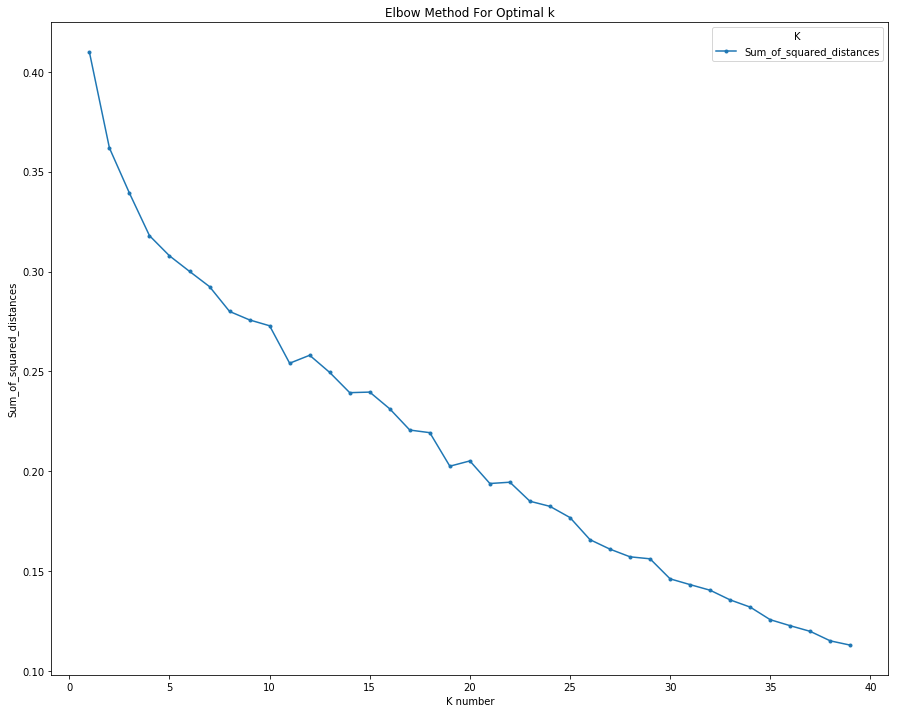

In [100]:
optimal_k.plot(kind = 'line', figsize = (15, 12), marker = '.')
plt.xlabel('K number')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Thank you!